##ThinkDSP

This notebook contains code examples from Chapter 9: Differentiation and Integration

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
from __future__ import print_function, division

import thinkdsp
import thinkplot
import math
import numpy as np
import pandas
import scipy.signal

PI2 = 2 * math.pi

%matplotlib inline

As the first example, I'll look at daily closing stock prices for Facebook, from its IPO on 17 May 2012 to 8 December 2015 (note: the dataset includes only trading days )

In [2]:
df = pandas.read_csv('fb.csv', parse_dates=[0])
ys = df.Close.values[::-1]
len(ys)

896

Here's what the time series looks like:

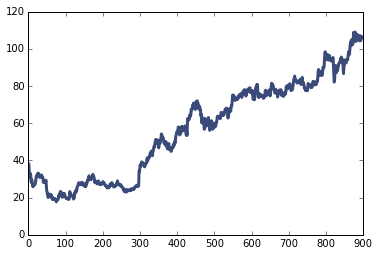

In [3]:
close = thinkdsp.Wave(ys, framerate=1)
close.plot()

And here's the spectrum on a log-log scale.

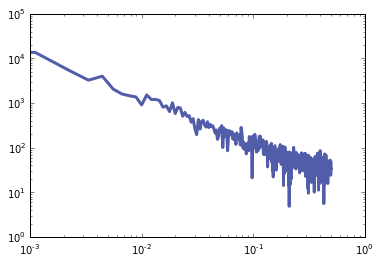

In [4]:
close_spectrum = close.make_spectrum()
close_spectrum.plot()
thinkplot.config(xscale='log', yscale='log', legend=False)

The slope is -1.86, which is similar to red noise (which should have a slope of -2).

In [5]:
close_spectrum.estimate_slope()

LinregressResult(slope=-1.8579804334942203, intercept=5.3354560372269386, rvalue=-0.90619055689452632, pvalue=8.0847980968848389e-169, stderr=0.041054485162360523)

We can use `np.diff` to compute the difference between successive elements, which is the daily change.

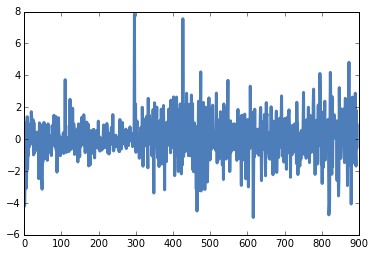

In [6]:
change = thinkdsp.Wave(np.diff(ys), framerate=1)
change.plot()

And here's the spectrum of the daily changes:

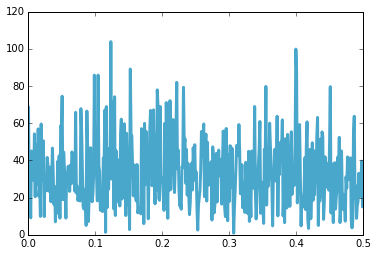

In [7]:
change_spectrum = change.make_spectrum()
change_spectrum.plot()

And here's the spectrum on a log-log scale.

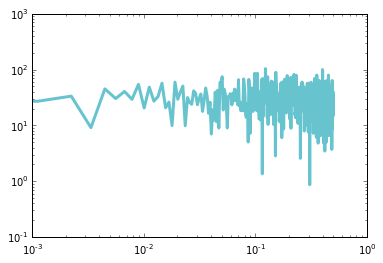

In [8]:
change_spectrum.plot()
thinkplot.config(xscale='log', yscale='log', legend=False)

The estimated slope is close to zero, which is consistent with white noise.

In [9]:
change_spectrum.estimate_slope()

LinregressResult(slope=-0.0572721329413532, intercept=6.5426032455765712, rvalue=-0.041292155443599855, pvalue=0.38378622973608567, stderr=0.065693929072567256)

We can think the diff operation as convolution with a difference window, [1, -1].  Convolution with this window corresponds to multiplication by a filter.

The following function computes the filter that corresponds to the window.

In [10]:
def make_filter(window, wave):
    """Computes the filter that corresponds to a window.
    
    window: NumPy array
    wave: wave used to choose the length and framerate
    
    returns: new Spectrum
    """
    padded = thinkdsp.zero_pad(window, len(wave))
    wave = thinkdsp.Wave(padded, framerate=wave.framerate)
    philter = wave.make_spectrum()
    return philter

And here's what the corresponding filter looks like:

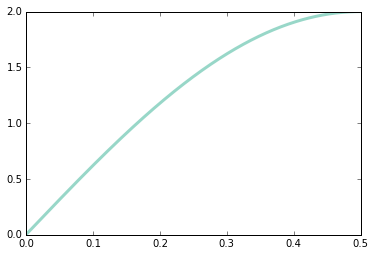

In [11]:
diff_window = np.array([1.0, -1.0])
diff_filter = make_filter(diff_window, close)
diff_filter.plot()

And the angles:

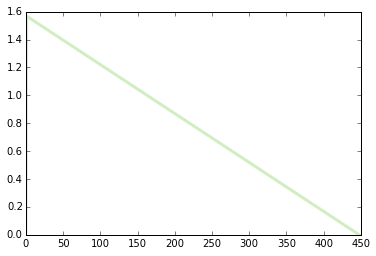

In [12]:
thinkplot.plot(diff_filter.angles())

So we could also compute the daily changes by multiplying the spectrum of closing prices by the diff filter:

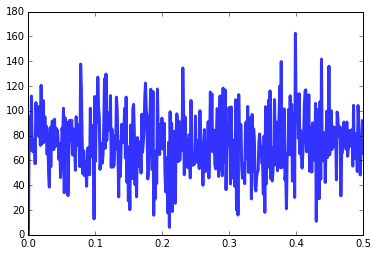

In [13]:
change_spectrum2 = close_spectrum * diff_filter
change_spectrum2.plot()

And then converting the spectrum to a wave.

In the result, the first element is wrong, so I remove it.

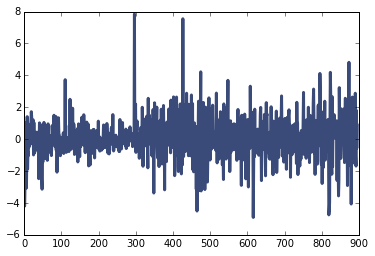

In [14]:
change2 = change_spectrum2.make_wave()
change2.ys = change2.ys[1:]
change2.plot()

The we can confirm that we get the same result both ways (within floating point error)

In [15]:
max(abs(change.ys - change2.ys))

3.1308289294429414e-13

This diff operation is an approximation of differentiation, and we can compute the filter for differentiation analytically: each complex component is multiplied by $2 \pi i f$.

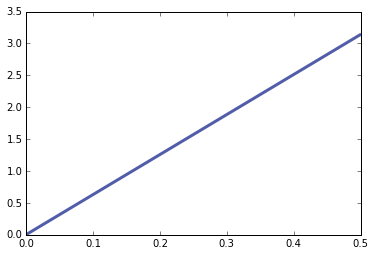

In [16]:
deriv_filter = close.make_spectrum()
i = complex(0, 1)
deriv_filter.hs = PI2 * i * deriv_filter.fs
deriv_filter.plot()

Now we can multiply the closing prices by the derivative filter:

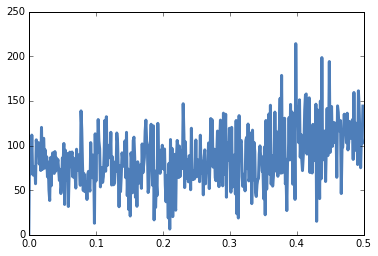

In [17]:
deriv_spectrum = close_spectrum * deriv_filter
deriv_spectrum.plot()

The results are similar, with some differences due to (1) the difference window is only a coarse approximation of the derivative, especially at higher frequencies, and (2) the spectral derivative is based on the assumption that the signal is periodic, so the behavior at the beginning and end is different.

In [18]:
deriv = deriv_spectrum.make_wave()
len(deriv), len(change)

(896, 895)

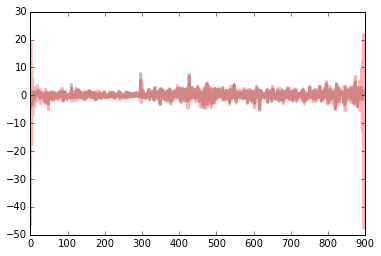

In [19]:
deriv = deriv_spectrum.make_wave()
change.plot(color='gray', alpha=0.5)
deriv.plot(color='red', alpha=0.3)

We can see the differences more clearly by zooming in on a section in the middle:

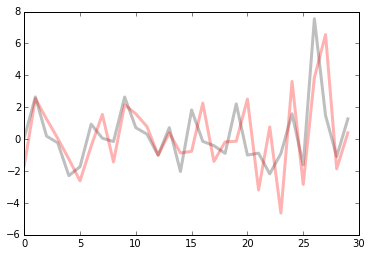

In [20]:
low, high = 400, 430
thinkplot.plot(change.ys[low:high], color='gray', alpha=0.5)
thinkplot.plot(deriv.ys[low:high], color='red', alpha=0.3)

The differences and derivative are similar in many places, but sometimes substantially different.

Here's the difference between the derivative filter and the difference filter:

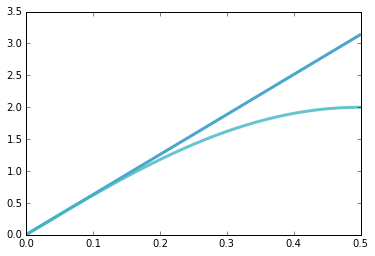

In [21]:
deriv_filter.plot()
diff_filter.plot()

The difference filter does not amplify the highest frequencies as much, which is why it is smoother than the derivative.

## Integration

Now let's think about integration.  We can compute the filter for integration analytically: each frequency component gets divided by $2 \pi i f$.

I plot the result on a log-y scale so we can see it more clearly.

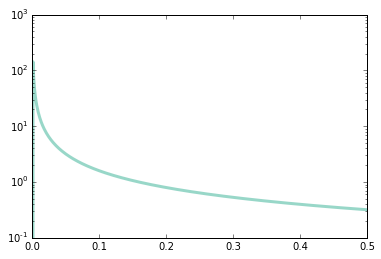

In [22]:
integ_filter = deriv_filter.copy()
i = complex(0, 1)
integ_filter.hs = 1 / (PI2 * i * integ_filter.fs)
integ_filter.hs[0] = 0
integ_filter.plot()
thinkplot.config(yscale='log')

In [23]:
len(deriv_spectrum), len(integ_filter)

(449, 449)

We can confirm that the integration filter is correct by applying it to the spectrum of the derivative we just computed:

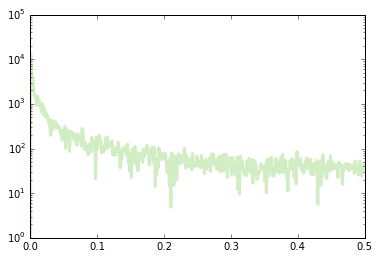

In [24]:
integ_spectrum = deriv_spectrum * integ_filter
integ_spectrum.plot()
thinkplot.config(yscale='log', legend=False)

And then converting back to a wave.  The result is identical to the daily closing prices we started with, but shifted so the mean is 0.  The problem is that the derivative clobbers the first element of the spectrum, which is the bias.  Once the bias information is lost, integration can't restore it.  So the result has an unspecified constant of integration.

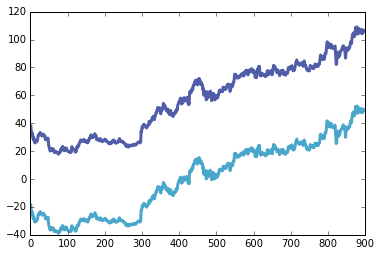

In [25]:
thinkplot.preplot(2)
integ_wave = integ_spectrum.make_wave()
close.plot(label='closing prices')
integ_wave.plot(label='integrated derivative')

In [26]:
shift = np.mean(close.ys) - np.mean(integ_wave.ys)
max(abs(integ_wave.ys-close.ys+shift))

2.4158453015843406e-13

In the same way that the diff operator approximates differentiation, the cumulative sum approximates integration.  The following figure shows the cumulative sum of the daily changes:

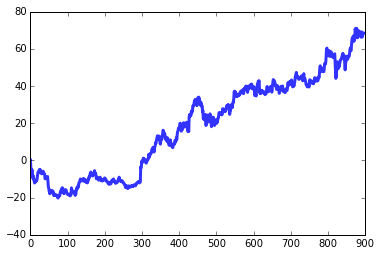

In [27]:
cumsum_wave = change.copy()
cumsum_wave.ys = np.cumsum(cumsum_wave.ys)
cumsum_wave.plot()

Unlike the difference operator, it's not obvious how to write the cumulative sum in terms of convolution with a window.  But since cumsum is the inverse operation of diff, it's filter must be the inverse of `diff_filter`:

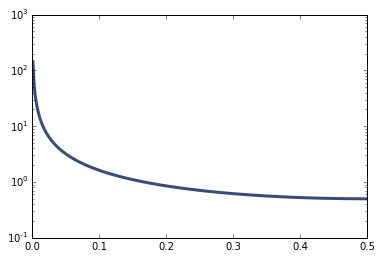

In [28]:
cumsum_filter = make_filter(diff_window, change).invert()
cumsum_filter.plot()
thinkplot.config(yscale='log', legend=False)

We can confirm that by computing the ratio of the cumsum spectrum to the change spectrum:

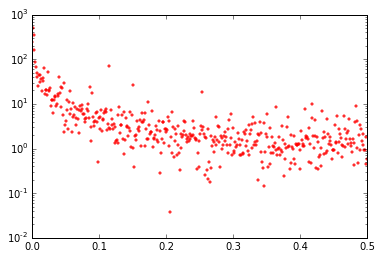

In [29]:
cumsum_spectrum = cumsum_wave.make_spectrum()
ratio_spectrum = cumsum_spectrum.ratio(change_spectrum)
ratio_spectrum.plot(style='.', color='red', markersize=5)
thinkplot.config(yscale='log')

The computed ratios have the same general shape as the filter, but they are noisy and might be offet by a constant factor.  I'm not sure what's going on there.

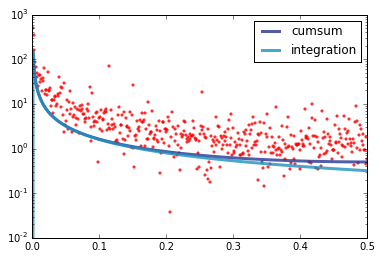

In [30]:
thinkplot.preplot(2)
ratio_spectrum.plot(style='.', color='red', markersize=5)
cumsum_filter.plot(label='cumsum')
integ_filter.plot(label='integration')
thinkplot.config(yscale='log', legend=True)

###An example that's actually periodic

We can do the same thing using a periodic signal like a sawtooth:

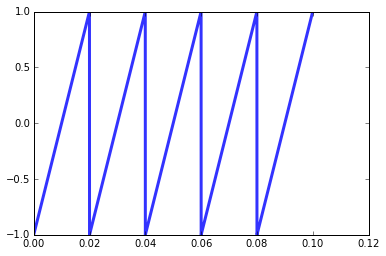

In [31]:
in_wave = thinkdsp.SawtoothSignal(freq=50).make_wave(duration=0.1, framerate=44100)
in_wave.plot()

Here's the spectrum before the cumulative sum:

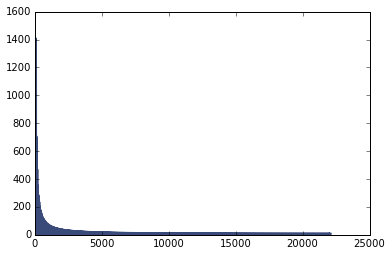

In [32]:
in_spectrum = in_wave.make_spectrum()
in_spectrum.plot()

The output wave is the cumulative sum of the input

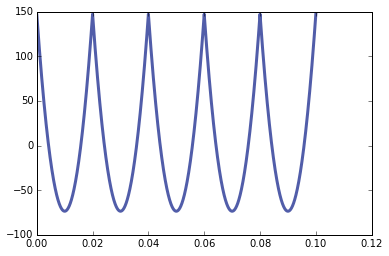

In [33]:
out_wave = in_wave.cumsum()
out_wave.unbias()
out_wave.plot()

And here's its spectrum

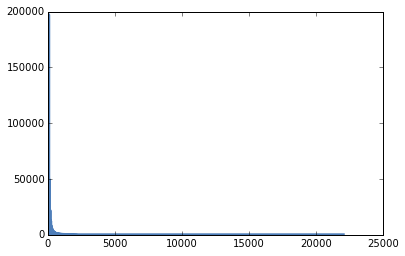

In [34]:
out_spectrum = out_wave.make_spectrum()
out_spectrum.plot()

Now we compute the ratio of the output to the input:

In [35]:
sum(in_spectrum.amps < 1), len(in_spectrum)

(1765, 2206)

In between the harmonics, the input componenents are small, so I set those ratios to NaN.

(1765, 2206)

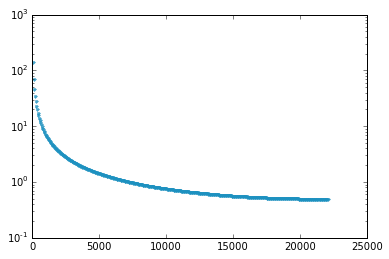

In [36]:
ratio_spectrum = out_spectrum.ratio(in_spectrum, thresh=1e-11, val=np.nan)
ratio_spectrum.plot(style='.')

thinkplot.config(yscale='log', legend=False)
sum(np.isnan(ratio_spectrum.hs)), len(ratio_spectrum)

To get the cumsum filter, I compute the diff filter again and invert it.

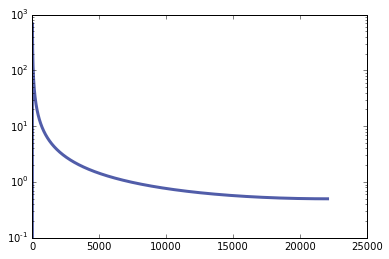

In [37]:
diff_window = np.array([1.0, -1.0])
diff_filter2 = make_filter(diff_window, in_wave)
cumsum_filter2 = diff_filter2.invert()
cumsum_filter2.hs[0] = 0

thinkplot.preplot(1)
cumsum_filter2.plot()
thinkplot.config(yscale='log', legend=False)

Finally, we can compare the computed ratios to the filter.  They match, confirming that the cumsum filter is the inverse of the diff filter.

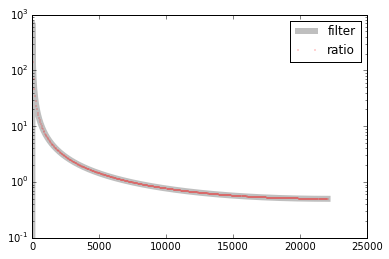

In [38]:
cumsum_filter2.plot(label='filter', color='gray', alpha=0.5, linewidth=6)
ratio_spectrum.plot(label='ratio', style='.', color='red', alpha=0.7, markersize=1)
thinkplot.config(yscale='log', legend=True)

Now we can compute the output wave using the convolution theorem, and compare the results:

In [39]:
len(in_spectrum), len(cumsum_filter2)

(2206, 2206)

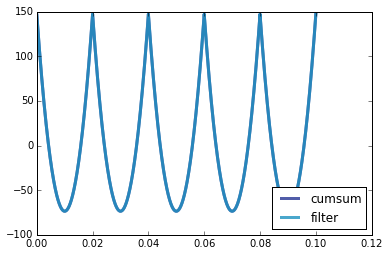

In [40]:
thinkplot.preplot(2)

out_wave.plot(label='cumsum')

out_wave2 = (in_spectrum * cumsum_filter2).make_wave()
out_wave2.plot(label='filter')

thinkplot.config(legend=True, loc='lower right')

They are the same, within floating point error.

In [41]:
max(abs(out_wave.ys - out_wave2.ys))

1.3180567748349858e-12

Since we're figured out the filter that corresponds to cumulative sum, we can compute the window that corresponds to the filter.

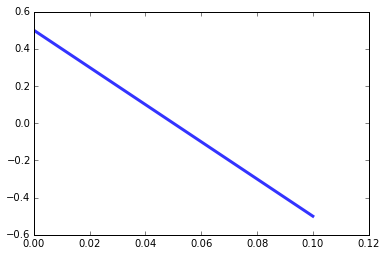

In [42]:
cumsum_window2 = cumsum_filter2.make_wave()
cumsum_window2.ys += 0
cumsum_window2.plot()

Convolving with this window should be the same as applying the cumsum function.

In [43]:
len(cumsum_window2), len(in_wave)

(4410, 4410)

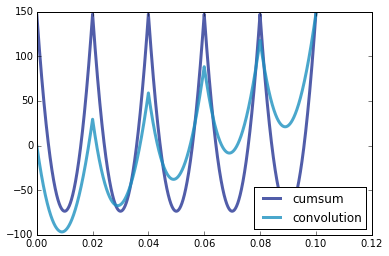

In [44]:
thinkplot.preplot(2)

out_wave.plot(label='cumsum')

out_wave3 = in_wave.convolve(cumsum_window2)
out_wave3.plot(label='convolution')

thinkplot.config(legend=True, loc='lower right')

But it's not.  One problem is that the version computed with cumsum starts at 150, but that's because I unbiased it.  The convolution starts at 0, as it should.

The other problem is that the convolution has a trend that shouldn't be there and a smaller magnitude.  In terms of frequencies, it looks like there's a lot of energy at a very low frequency, and energy has been sapped from the higher frequencies.  So what's going on there?